In [10]:
import numpy as np
import pandas as pd
from itertools import combinations
from dataclasses import dataclass
from typing import Dict, List, Tuple, Optional
import matplotlib.pyplot as plt


=== Biases (median In-situ - Satellite) ===
          SMAP: +0.406228
         GLDAS: +0.410435
          ERA5: +0.292925

=== RMSE Calibration (per series) ===
                SMAP | a=+0.352823, b=+0.559730, RMSE_before=0.4097, RMSE_after=0.0357, n=1322
               GLDAS | a=+0.199165, b=+0.596335, RMSE_before=0.4111, RMSE_after=0.0396, n=1322
                ERA5 | a=+0.035639, b=+0.631513, RMSE_before=0.3290, RMSE_after=0.0402, n=1322
       SMAP_biascorr | a=+0.352823, b=+0.416403, RMSE_before=0.0497, RMSE_after=0.0357, n=1322
      GLDAS_biascorr | a=+0.199165, b=+0.514591, RMSE_before=0.0505, RMSE_after=0.0396, n=1322
       ERA5_biascorr | a=+0.035639, b=+0.621074, RMSE_before=0.0950, RMSE_after=0.0402, n=1322

=== Triple Collocation Weights ===
       SMAP_biascorr: 0.0000
      GLDAS_biascorr: 0.5000
             In_Situ: 0.5000

=== RMSE-blend Weights (sum=1) ===
   SMAP_biascorr_cal: 1.0000
  GLDAS_biascorr_cal: 0.0000
   ERA5_biascorr_cal: 0.0000


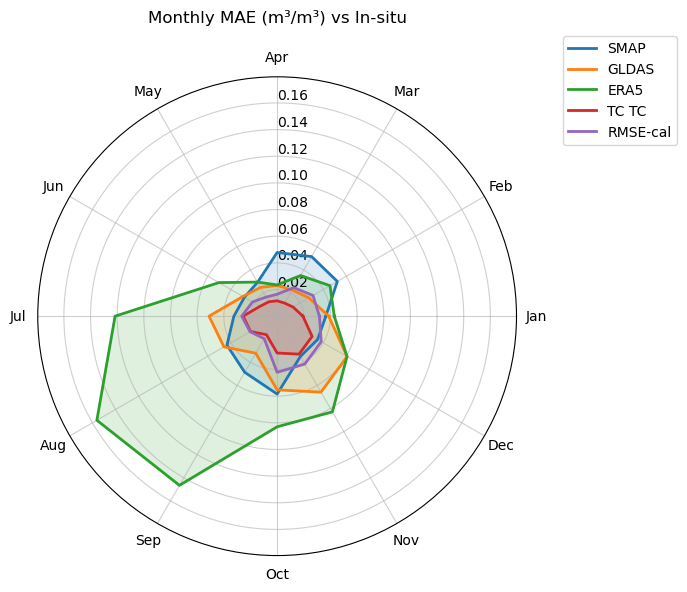

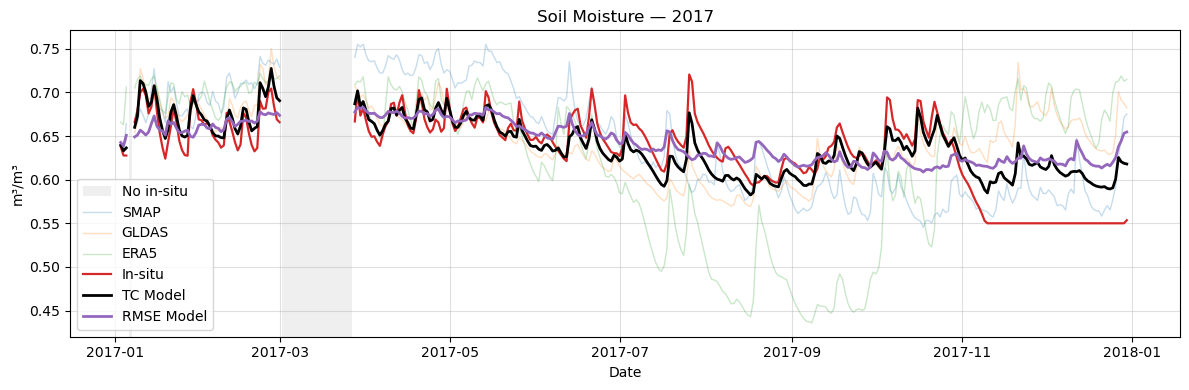

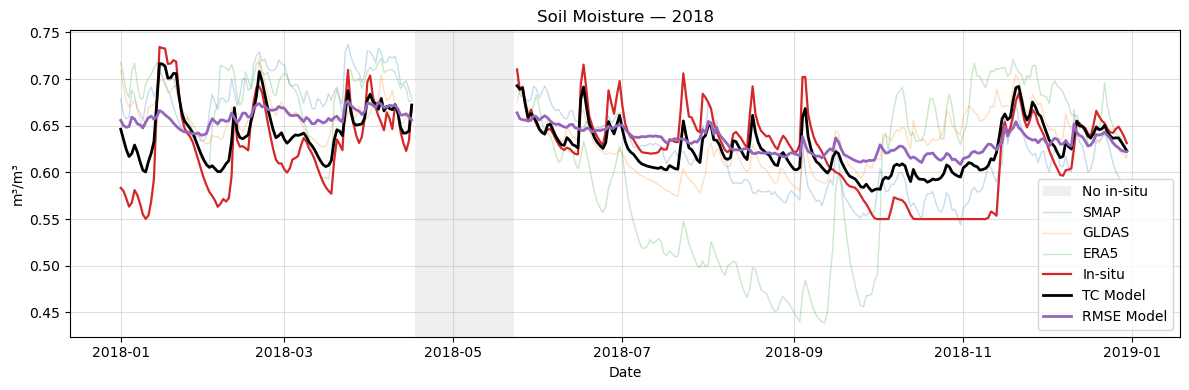

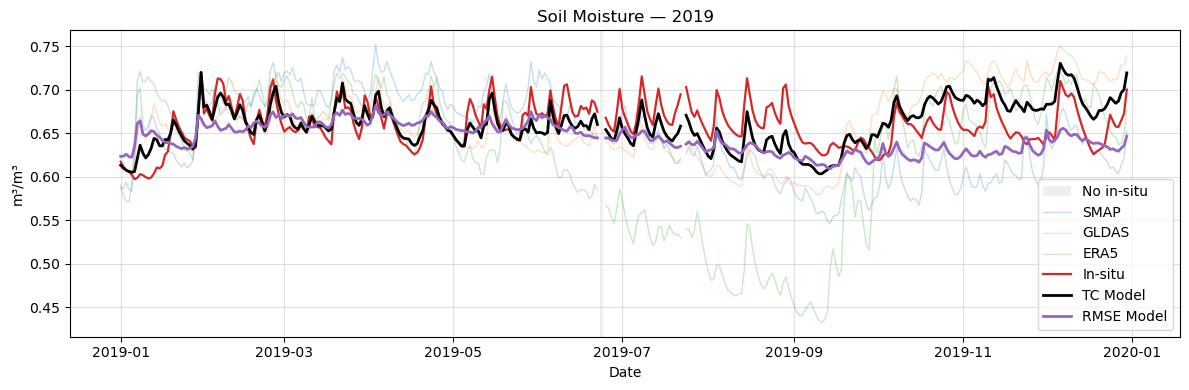

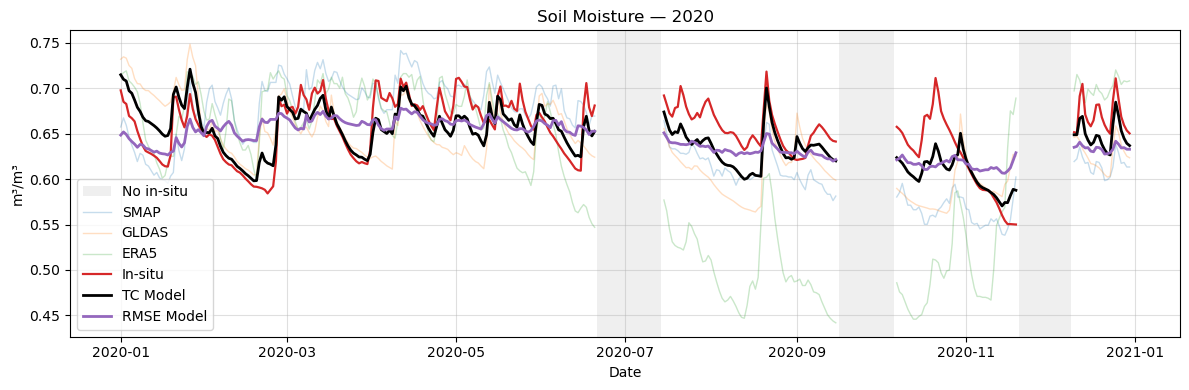

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Dict, List, Tuple, Optional


# =========================
# Utilities
# =========================
def _ensure_wide(df: pd.DataFrame, date_col: Optional[str] = None) -> tuple[pd.DataFrame, str, str, List[str]]:
    """
    Normalize input to a *wide* layout and clean types.

    Expected column order (by position):
        0: date
        1: in-situ reference series
        2+: satellite series (one or more)

    Returns
    -------
    d : cleaned DataFrame
    date_col : name of the date column
    ref_col  : name of the in-situ column (second column)
    sat_cols : list of satellite column names (columns 3+)
    """
    d = df.copy()

    # Infer column names if user did not pass date_col explicitly
    if date_col is None:
        date_col = d.columns[0]
    ref_col = d.columns[1]

    # Any column other than date & in-situ is treated as a satellite series
    sat_cols = [c for c in d.columns if c not in (date_col, ref_col)]
    if not sat_cols:
        raise ValueError("No satellite columns found. Expected: date | in-situ | sat1 | sat2 | ...")

    # Type-cast and sort by time
    d[date_col] = pd.to_datetime(d[date_col], errors="coerce")
    d = d.dropna(subset=[date_col]).sort_values(date_col).reset_index(drop=True)

    # Coerce numeric series; keep NaNs if any
    for c in [ref_col] + sat_cols:
        d[c] = pd.to_numeric(d[c], errors="coerce")

    return d, date_col, ref_col, sat_cols


def _rmse(a, b):
    """Root-Mean-Square Error with safe NaN handling (pairwise finite)."""
    m = np.isfinite(a) & np.isfinite(b)
    return float(np.sqrt(np.mean((a[m] - b[m])**2))) if m.any() else np.nan


# =========================
# 1) Bias correction (median)
# =========================
def bias_correction_median(df: pd.DataFrame) -> tuple[pd.DataFrame, Dict[str, float]]:
    """
    Apply a constant bias correction per satellite using the median of
    (in_situ - satellite). For each satellite 'SAT', add a new column:

        SAT_biascorr = SAT + median(in_situ - SAT)

    Returns the augmented DataFrame and a dict of per-satellite bias values.
    """
    d, date_col, ref_col, sat_cols = _ensure_wide(df)
    biases: Dict[str, float] = {}

    for sat in sat_cols:
        # Robust constant bias (median is less sensitive to outliers)
        bias = (d[ref_col] - d[sat]).median(skipna=True)
        d[f"{sat}_biascorr"] = d[sat] + bias
        biases[sat] = float(bias)

    return d, biases


# =========================
# 2) RMSE calibration (OLS) for each series to in-situ
# =========================
@dataclass
class RmseCalib:
    """Store per-series calibration stats."""
    a: float                 # slope of linear fit  (ref ≈ a*series + b)
    b: float                 # intercept of linear fit
    rmse_before: float       # RMSE(series, ref) before calibration
    rmse_after: float        # RMSE(a*series+b, ref) after calibration
    n_used: int              # number of overlapping timestamps used


def rmse_calibrate_to_insitu(df: pd.DataFrame) -> tuple[pd.DataFrame, Dict[str, RmseCalib]]:
    """
    For each satellite (raw and *_biascorr if present), fit a linear model
        ref ≈ a*series + b
    on overlapping timestamps, and append a calibrated column '<col>_cal'.

    Returns the DataFrame with *_cal columns and a dict of RmseCalib stats.
    """
    d, date_col, ref_col, sat_cols = _ensure_wide(df)
    out = d.copy()
    metrics: Dict[str, RmseCalib] = {}

    # Calibrate both raw satellites and already bias-corrected versions
    targets = sat_cols + [f"{s}_biascorr" for s in sat_cols if f"{s}_biascorr" in d.columns]

    for col in targets:
        pair = out[[ref_col, col]].dropna()
        n = len(pair)
        if n < 2:
            # Too few points to fit; write NaNs and continue
            metrics[col] = RmseCalib(np.nan, np.nan, np.nan, np.nan, n)
            out[f"{col}_cal"] = np.nan
            continue

        # Ordinary Least Squares: solve for a, b
        y = pair[ref_col].to_numpy()
        x = pair[col].to_numpy()
        X = np.vstack([x, np.ones_like(x)]).T
        a, b = np.linalg.lstsq(X, y, rcond=None)[0]

        # Apply calibration to the full series (not only overlapping dates)
        out[f"{col}_cal"] = a * out[col] + b

        # Store diagnostics
        metrics[col] = RmseCalib(
            float(a), float(b),
            _rmse(y, x),           # before
            _rmse(y, a*x + b),     # after
            n
        )

    return out, metrics


# =========================
# 3) Triple collocation (exactly 3 series)
# =========================
@dataclass
class TcResult:
    """Container for triple collocation output."""
    cols: tuple[str, str, str]   # (sat1, sat2, reference)
    weights: Dict[str, float]    # normalized weights for the three inputs
    cov: pd.DataFrame            # covariance matrix used


def triple_collocation_on_triple(df: pd.DataFrame, cols3: List[str], eps: float = 1e-12) -> TcResult:
    """
    Run the classic 3-variable triple collocation on columns [s1, s2, ref].

    Notes
    -----
    - Requires exactly 3 inputs with sufficient overlap.
    - Produces normalized weights (sum=1) ~ 1/error_proxies from covariances.
    """
    if len(cols3) != 3:
        raise ValueError("Triple collocation requires EXACTLY three columns.")

    d = df[cols3].dropna()
    if len(d) < 3:
        raise ValueError("Not enough overlapping points for triple collocation.")

    covm = d.cov()
    s1, s2, ref = cols3

    # Shorthand covariances
    c12 = covm.loc[s1, s2]
    c1y = covm.loc[s1, ref]
    c2y = covm.loc[s2, ref]

    # Error proxies (same algebra used earlier)
    den1 = (c12 + c2y - 2*c1y) + eps
    den2 = (c12 + c2y - 2*c12) + eps
    e1   = (c2y - c1y) / den1
    e2   = (c1y - c12) / den2
    ey   = (c12 - c2y) / den2

    # Weights ∝ 1/error; normalize to sum=1
    w1 = 1.0 / max(e1, eps)
    w2 = 1.0 / max(e2, eps)
    wy = 1.0 / max(ey, eps)
    s  = w1 + w2 + wy
    weights = {s1: float(w1/s), s2: float(w2/s), ref: float(wy/s)}

    return TcResult(cols=tuple(cols3), weights=weights, cov=covm)


# =========================
# 4) RMSE-blend model (nonnegative weights that sum to 1)
# =========================
def _score(y_true, y_pred, metric="rmse"):
    """Compute RMSE (default) or MAE between arrays/Series."""
    y_true = y_true.values if hasattr(y_true, "values") else y_true
    y_pred = y_pred.values if hasattr(y_pred, "values") else y_pred
    if metric.lower() == "mae":
        return np.mean(np.abs(y_true - y_pred))
    else:
        return np.sqrt(np.mean((y_true - y_pred)**2))


def learn_sat_only_weights(df, sat_cols, target_col="In_Situ", metric="rmse", step=0.02):
    """
    Learn convex weights (>=0, sum=1) for 1–3 satellite inputs that minimize
    an error metric to the in-situ target on overlapping timestamps.

    Uses a simple grid search over the simplex:
      - 2 vars: w, 1-w
      - 3 vars: w1, w2, 1-w1-w2 (with w1+w2 ≤ 1)
    """
    data = pd.concat([df[sat_cols], df[target_col]], axis=1).dropna()
    if data.empty:
        raise ValueError("No aligned data to learn satellite-only weights.")

    X = data[sat_cols]
    y = data[target_col]
    n = len(sat_cols)

    if n == 1:
        return {sat_cols[0]: 1.0}

    best_w = None
    best_score = np.inf

    if n == 2:
        grid = np.arange(0.0, 1.0 + 1e-9, step)
        for w1 in grid:
            w = np.array([w1, 1.0 - w1])
            s = _score(y, X.values @ w, metric)
            if s < best_score:
                best_score, best_w = s, w

    elif n == 3:
        grid = np.arange(0.0, 1.0 + 1e-9, step)
        for w1 in grid:
            for w2 in grid:
                if w1 + w2 <= 1.0 + 1e-12:
                    w3 = 1.0 - (w1 + w2)
                    w = np.array([w1, w2, w3])
                    s = _score(y, X.values @ w, metric)
                    if s < best_score:
                        best_score, best_w = s, w
    else:
        raise ValueError("This helper supports 1–3 satellite series.")

    wdict = {col: float(w) for col, w in zip(sat_cols, best_w)}
    # Numerical nudge to guarantee exact sum=1
    total = sum(wdict.values())
    for k in wdict:
        wdict[k] /= total
    return wdict


# =========================
# 5) Orchestrator (bias → RMSE-cal → TC → RMSE-blend) + summaries
# =========================
def run_full_calibration_pipeline(
    df_wide: pd.DataFrame,
    date_col: Optional[str] = None,
    tc_satellite_pair: Optional[Tuple[str, str]] = None,   # e.g., ('SMAP','GLDAS')
    in_situ_name: Optional[str] = None                     # if your in-situ column has a specific name
) -> Dict[str, object]:
    """
    End-to-end routine:
      1) enforce layout & types,
      2) bias-correct satellites,
      3) per-series RMSE calibration (linear fit to reference),
      4) optional triple collocation on a chosen sat pair + reference,
      5) RMSE-optimal convex blend of calibrated/biascorr satellites,
      6) print diagnostics and return the augmented DataFrame + metadata.
    """
    # Normalize layout and optionally switch which column is the in-situ reference
    d0, date_col, ref_col, sat_cols = _ensure_wide(df_wide, date_col=date_col)
    if in_situ_name and in_situ_name != ref_col:
        if in_situ_name not in d0.columns:
            raise ValueError(f"'{in_situ_name}' not in df.")
        order = [date_col, in_situ_name] + [c for c in d0.columns if c not in (date_col, in_situ_name)]
        d0 = d0[order]
        d0, date_col, ref_col, sat_cols = _ensure_wide(d0, date_col=date_col)

    # (1) Bias correction
    d_bias, biases = bias_correction_median(d0)

    # (2) RMSE calibration (adds *_cal for raw & *_biascorr where possible)
    d_cal, rmse_metrics = rmse_calibrate_to_insitu(d_bias)

    out = {
        "date_col": date_col,
        "ref_col": ref_col,
        "sat_cols": sat_cols,
        "biases": biases,
        "rmse_metrics": rmse_metrics,
        "tc_result": None,
        "rmse_blend_weights": None,
        "df": d_cal,   # final working table (also holds TC_Model / RMSE_Model if computed)
    }

    # (3) Triple Collocation on a selected pair (bias-corrected versions) + reference
    if tc_satellite_pair:
        s1, s2 = tc_satellite_pair
        cols3 = [f"{s1}_biascorr", f"{s2}_biascorr", ref_col]
        tc = triple_collocation_on_triple(d_cal, cols3)
        out["tc_result"] = tc
        w = tc.weights
        d_cal["TC_Model"] = (
            w[cols3[0]] * d_cal[cols3[0]]
            + w[cols3[1]] * d_cal[cols3[1]]
            + w[cols3[2]] * d_cal[cols3[2]]
        )

    # (4) RMSE-blended model (prefer calibrated bias-corrected columns)
    candidate_cols = [f"{s}_biascorr_cal" for s in sat_cols if f"{s}_biascorr_cal" in d_cal.columns]
    if not candidate_cols:
        candidate_cols = [f"{s}_biascorr" for s in sat_cols if f"{s}_biascorr" in d_cal.columns]

    wdict = learn_sat_only_weights(
        d_cal.set_index(date_col),
        candidate_cols,
        target_col=ref_col,
        metric="rmse",
        step=0.02
    )
    out["rmse_blend_weights"] = wdict

    # Build blended time series and append as "RMSE_Model"
    rmse_model = None
    for c, w in wdict.items():
        rmse_model = (w * d_cal[c]) if rmse_model is None else (rmse_model + w * d_cal[c])
    d_cal["RMSE_Model"] = rmse_model

    # Human-readable summaries
    print("\n=== Biases (median In-situ - Satellite) ===")
    for s, b in biases.items():
        print(f"  {s:>12}: {b:+.6f}")

    print("\n=== RMSE Calibration (per series) ===")
    for col, m in rmse_metrics.items():
        print(f"  {col:>18} | a={m.a:+.6f}, b={m.b:+.6f}, RMSE_before={m.rmse_before:.4f}, RMSE_after={m.rmse_after:.4f}, n={m.n_used}")

    if out["tc_result"]:
        print("\n=== Triple Collocation Weights ===")
        for k, v in out["tc_result"].weights.items():
            print(f"  {k:>18}: {v:.4f}")

    print("\n=== RMSE-blend Weights (sum=1) ===")
    for k, v in wdict.items():
        print(f"  {k:>18}: {v:.4f}")

    return out


# =========================
# 6) MAE Rose (includes RMSE model + TC model if present)
# =========================
def _monthly_mae(pred: pd.Series, ref: pd.Series) -> np.ndarray:
    """Compute month-wise mean absolute error for a (pred, ref) pair."""
    dfm = pd.concat([pred, ref], axis=1).dropna()
    if dfm.empty:
        return np.full(12, np.nan)
    dfm.columns = ["pred", "ref"]
    out = (
        dfm.assign(err=(dfm["pred"] - dfm["ref"]).abs())
           .groupby(dfm.index.to_period("M").to_timestamp().month)["err"].mean()
           .reindex(range(1, 13))
    )
    return out.values


def plot_mae_rose(df: pd.DataFrame, date_col: str, ref_col: str, series_cols: List[str],
                  labels=None, colors=None, title="Monthly MAE (m³/m³) vs In-situ"):
    """
    Polar (radar) chart of monthly MAE for each series against the reference.
    Pass the names of columns to compare in `series_cols`. The function will
    compute MAE per calendar month and plot it around the circle.
    """
    d = df.set_index(date_col)

    # Default labels/colors if not provided
    if labels is None:
        labels = series_cols
    if colors is None:
        base = ["tab:blue", "tab:orange", "tab:green", "tab:red",
                "tab:purple", "tab:brown", "tab:pink", "tab:gray",
                "tab:olive", "tab:cyan"]
        colors = [base[i % len(base)] for i in range(len(series_cols))]

    # Geometry for 12 months + wrap-around point
    theta = np.linspace(0, 2*np.pi, 12, endpoint=False)
    theta = np.r_[theta, theta[0]]

    fig = plt.figure(figsize=(7.2, 7.2))
    ax = fig.add_subplot(111, polar=True)
    months = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
    ax.set_xticks(np.linspace(0, 2*np.pi, 12, endpoint=False))
    ax.set_xticklabels(months)
    ax.set_rlabel_position(90)
    ax.grid(True, alpha=0.6)

    # Determine radial limit from all curves
    rmax = 0.0
    curves = []
    for col in series_cols:
        mae = _monthly_mae(d[col], d[ref_col])
        curves.append(mae)
        if np.isfinite(mae).any():
            rmax = max(rmax, np.nanmax(mae))
    ax.set_ylim(0, (rmax if np.isfinite(rmax) and rmax > 0 else 1.0) * 1.15)

    # Plot each curve
    for mae, lab, colr in zip(curves, labels, colors):
        vals = np.r_[mae, mae[0]]
        ax.plot(theta, vals, label=lab, color=colr, linewidth=2)
        ax.fill(theta, vals, color=colr, alpha=0.15)

    ax.legend(loc="upper right", bbox_to_anchor=(1.35, 1.10))
    ax.set_title(title, pad=20)
    plt.tight_layout()
    plt.show()


# =========================
# 7) Yearly time-series plot with gaps shaded
# =========================
def _gap_spans(idx: pd.DatetimeIndex, presence: pd.Series) -> List[tuple[pd.Timestamp, pd.Timestamp]]:
    """Return [ (start, end), ... ] spans for missing (False) presence on idx."""
    if len(idx) == 0:
        return []
    miss = (~presence.reindex(idx, fill_value=False)).to_numpy().astype(int)
    d = np.diff(np.r_[0, miss, 0])
    starts = np.where(d == 1)[0]
    ends   = np.where(d == -1)[0] - 1
    return [(idx[s], idx[e]) for s, e in zip(starts, ends)]


def plot_yearly_timeseries(df: pd.DataFrame, date_col: str, ref_col: str, sat_cols: List[str]):
    """
    For each year in the record, plot:
      - transparent bias-corrected satellites,
      - in-situ series,
      - optional TC and RMSE models,
      - gray shading where in-situ is missing (no line is drawn there).
    """
    d = df.set_index(date_col).sort_index()

    # Build a daily timeline and a presence mask from the in-situ data
    full_idx = pd.date_range(d.index.min(), d.index.max(), freq="D")
    ins_full = d[ref_col].reindex(full_idx)
    presence = ins_full.notna()

    def shade(ax, spans):
        """Draw gray rectangles for missing in-situ intervals."""
        first = True
        for a, b in spans:
            ax.axvspan(a, b, color="lightgrey", alpha=0.35, lw=0,
                       zorder=0, label="No in-situ" if first else None)
            first = False

    # One figure per calendar year
    years = np.unique(full_idx.year)
    for y in years:
        year_idx = full_idx[full_idx.year == y]
        spans = _gap_spans(year_idx, presence)

        plt.figure(figsize=(12, 4))
        ax = plt.gca()
        shade(ax, spans)

        # Bias-corrected satellites (transparent)
        for s in sat_cols:
            col = f"{s}_biascorr"
            if col in d.columns:
                plt.plot(year_idx, d[col].reindex(year_idx), alpha=0.25, lw=1.0, label=s)

        # Reference and available models
        plt.plot(year_idx, ins_full.reindex(year_idx), color="tab:red", lw=1.6, label="In-situ")
        if "TC_Model" in d.columns:
            plt.plot(year_idx, d["TC_Model"].reindex(year_idx), color="k", lw=2.0, label="TC Model")
        if "RMSE_Model" in d.columns:
            plt.plot(year_idx, d["RMSE_Model"].reindex(year_idx), color="tab:purple", lw=2.0, label="RMSE Model")

        plt.title(f"Soil Moisture — {y}")
        plt.ylabel("m³/m³")
        plt.xlabel("Date")
        plt.grid(True, alpha=0.4)
        plt.legend()
        plt.tight_layout()
        plt.show()


# =========================
# Example usage
# =========================
# Your CSV must have columns in this order:
#   date | In_Situ | SMAP | GLDAS | ERA5 | ...
df_all = pd.read_csv(
    r"C:\Users\Jelle Gortemaker\OneDrive - Delft University of Technology\Documenten\0. MSc\MDP\Data\aligned_data.csv"
)

# Run the full pipeline; choose the pair for triple collocation (optional)
res = run_full_calibration_pipeline(df_all, tc_satellite_pair=("SMAP", "GLDAS"))

# Retrieve outputs
d_out, date_col, ref_col, sats = res["df"], res["date_col"], res["ref_col"], res["sat_cols"]

# Build the list of series to include in the MAE-rose (satellites + models)
series_for_rose = [f"{s}_biascorr" for s in sats if f"{s}_biascorr" in d_out.columns]
if "TC_Model" in d_out.columns:
    series_for_rose.append("TC_Model")
if "RMSE_Model" in d_out.columns:
    series_for_rose.append("RMSE_Model")

# Prettier labels for the legend
labels = [s.replace("_biascorr", "") for s in series_for_rose]
labels = [("TC TC" if l == "TC_Model" else ("RMSE-cal" if l == "RMSE_Model" else l)) for l in labels]

# Plot diagnostics
plot_mae_rose(d_out, date_col, ref_col, series_for_rose, labels=labels,
              title="Monthly MAE (m³/m³) vs In-situ")
plot_yearly_timeseries(d_out, date_col, ref_col, sats)
